# ДЗ-1

### Импорт библиотек

In [165]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error

### Пункт 1

Скачаем данные в формате csv.

In [166]:
path_to_data = "owid-covid-data.csv"
data = pd.read_csv(path_to_data, parse_dates=True)

In [167]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Выберем из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших).

In [168]:
data = data[(data["location"] == "Russia") & (data["date"] >= "2020-03-03")]
data.set_index("date", inplace=True)

В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы.

In [169]:
targets = ["total_cases", "new_cases"]

target_data = data[targets]

# muting the useless warning
pd.options.mode.chained_assignment = None
# simplify 'new_cases' column
target_data["new_cases"] = target_data["new_cases"].map(lambda value: value if value > 0 else 1)

Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [170]:
CARDINALITY_OF_TRAIN = 50

train_data = data[:CARDINALITY_OF_TRAIN]
test_data = data[CARDINALITY_OF_TRAIN:]

train_target = target_data[:CARDINALITY_OF_TRAIN]
test_target = target_data[CARDINALITY_OF_TRAIN:]

### Пункт 2

In [171]:
def plot_graphs(x, ys, title=None, labels=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(16, 9))
    
    for i in range(len(ys)):
        plt.plot(x, ys[i], label=labels[i] if labels else None)

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.legend()
    plt.show()

Строим графики для всех данных (на момент выгрузки датасета).

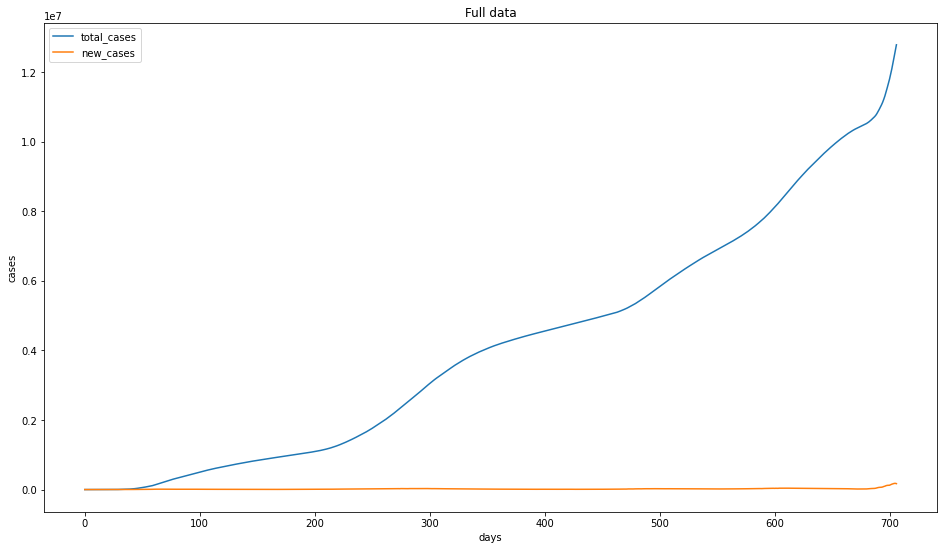

In [172]:
plot_graphs(range(len(data.index)), [data[target] for target in targets],
            title="Full data", labels=targets,
            xlabel="days", ylabel="cases")

Строим графики для тренировочных данных.

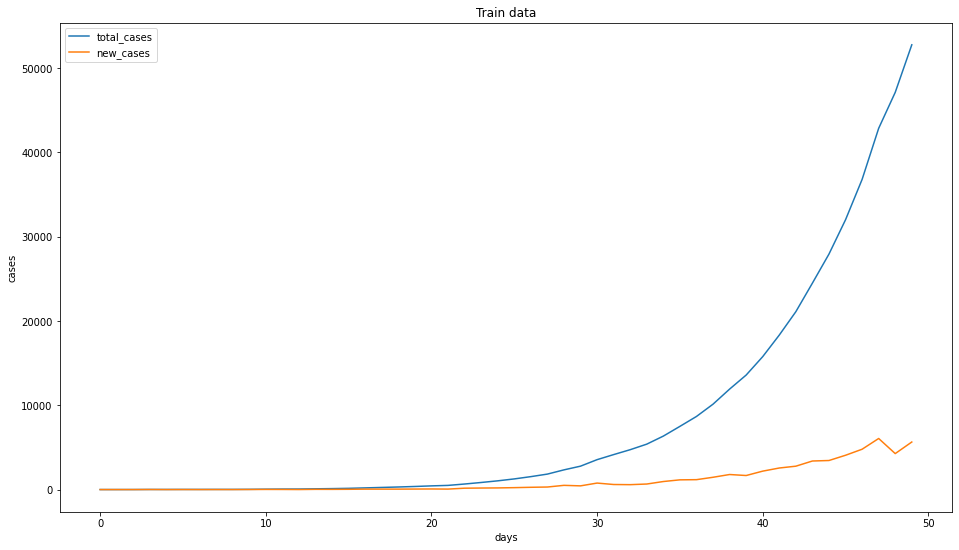

In [173]:
plot_graphs(range(len(train_target.index)), [train_target[target] for target in targets],
            title="Train data", labels=targets,
            xlabel="days", ylabel="cases")

Видим, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

#### Подпункт A

Используя линейную регрессию, обучим модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

Будем использовать линейную регрессию не для исходной функции, а сделаем небольшие (и обратимые) преобразования нашей целевой функций:

$$
y \sim exp(w * x + b);\\
y = C1 * exp(w * x + b);\\
ln(y) = ln(C1) + w * x + b;\\
$$

пускай $C2 = ln(C1) + b$ и $g = ln(y)$. В результате, функция для модели линейной регрессии будет выглдеть так:
$$g = w * x + C2;$$
тогда мы можем обратить предсказанный результат линейной регрессии, чтобы получить нашу исходную функцию: $y = exp(g)$.

In [174]:
train_target_log = pd.DataFrame()

for target in targets:
    train_target_log[target] = train_target[target].map(lambda value: math.log(value))

Проиллюстрируем нашу полученную функцию (по нашему предположению, она должна быть похожа на прямую).

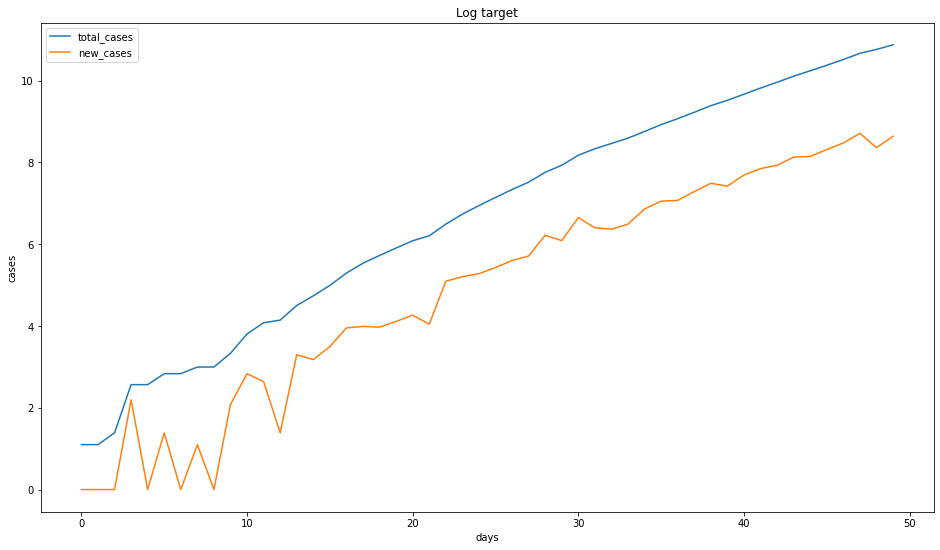

In [175]:
plot_graphs(range(len(train_target_log.index)), [train_target_log[target] for target in targets],
            title="Log target", labels=targets,
            xlabel="days", ylabel="cases")

Вроде такое можно пытаться аппроксимировать прямой :)

In [176]:
def linear_log(x, y, target=None, plot=False):
    model = linear_model.LinearRegression()
    model.fit(x, y)

    w = model.coef_
    b = model.intercept_
    print("w = {}, b = {}".format(w, b))

    pred = model.predict(x)

    if plot:
        plot_graphs(range(len(train_target_log.index)), [train_target_log[target], pred],
                    title="Liner regression for " + target,
                    xlabel="days", ylabel="cases")

    return (pred, w, b)

Посмотрим, насколько хорошо получилось это сделать.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


w = [0.19829091], b = 1.820737148784695


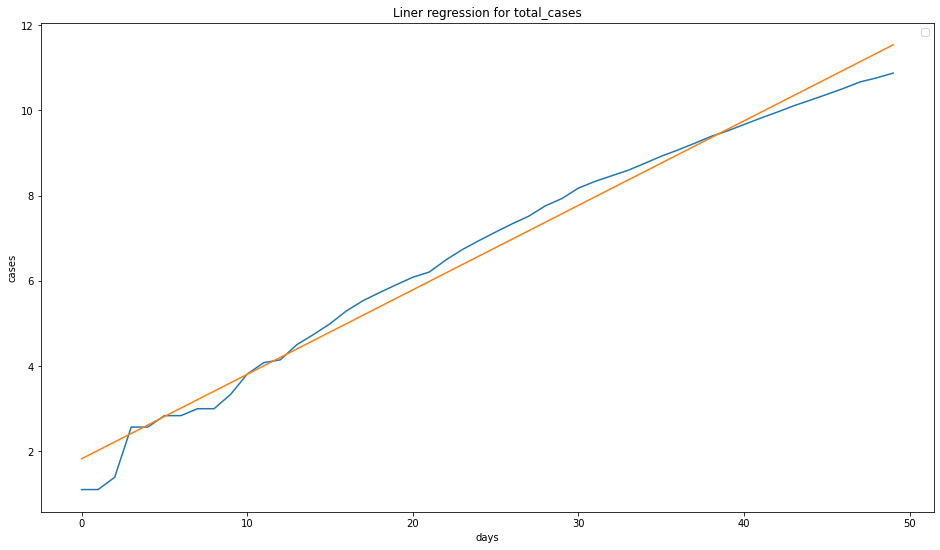

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


w = [0.18596309], b = 0.3206875188996463


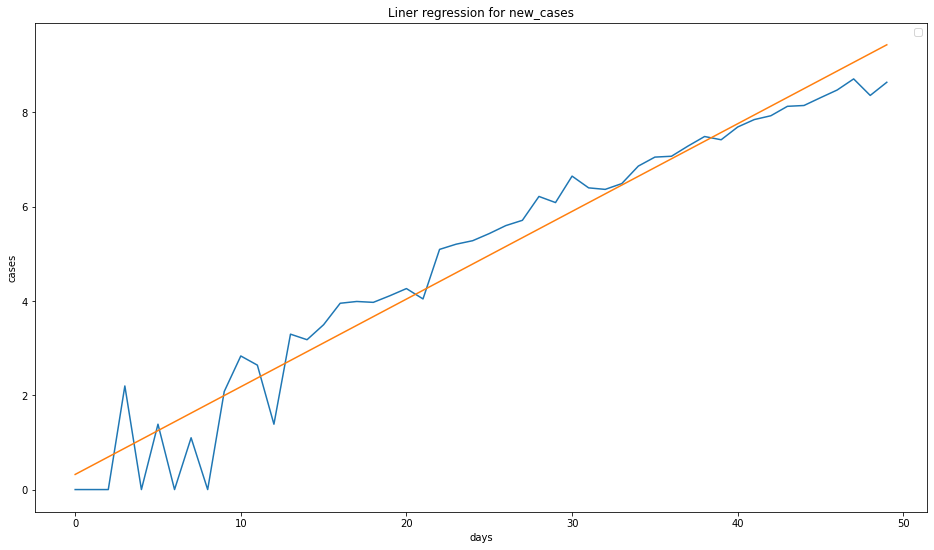

In [177]:
gs = []
ws = []
C2s = []

for target in targets:
    parameters = linear_log(np.array(range(len(train_target_log.index))).reshape(-1, 1),
                         train_target_log[target],
                         target, True)
    gs.append(parameters[0])
    ws.append(parameters[1])
    C2s.append(parameters[2])

Вроде неплохо. Теперь можем обратить выход линейной регрессии, чтобы найти значения изначальной целевой функции.

In [178]:
ys = []

for g in gs:
    ys.append([math.exp(value) for value in g])

Проиллюстрируем, что получилось.

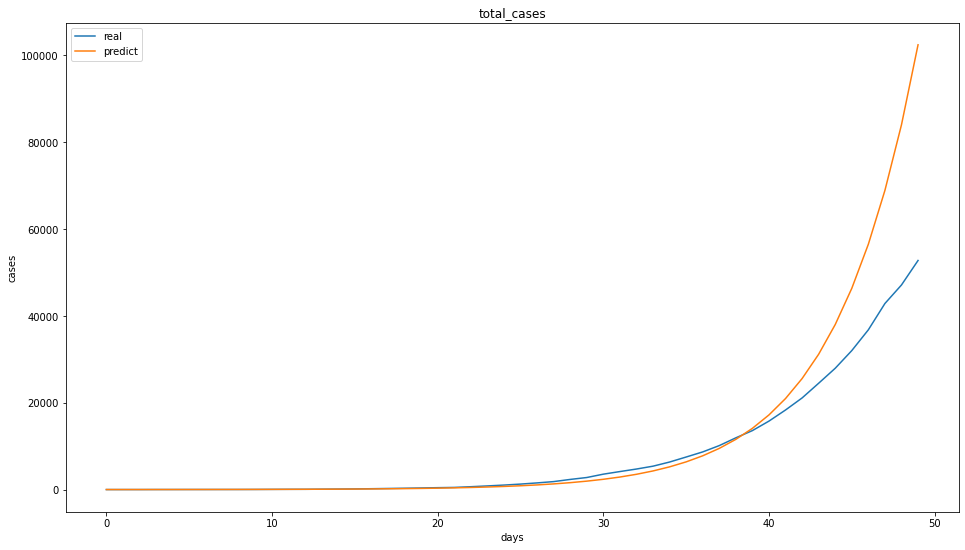

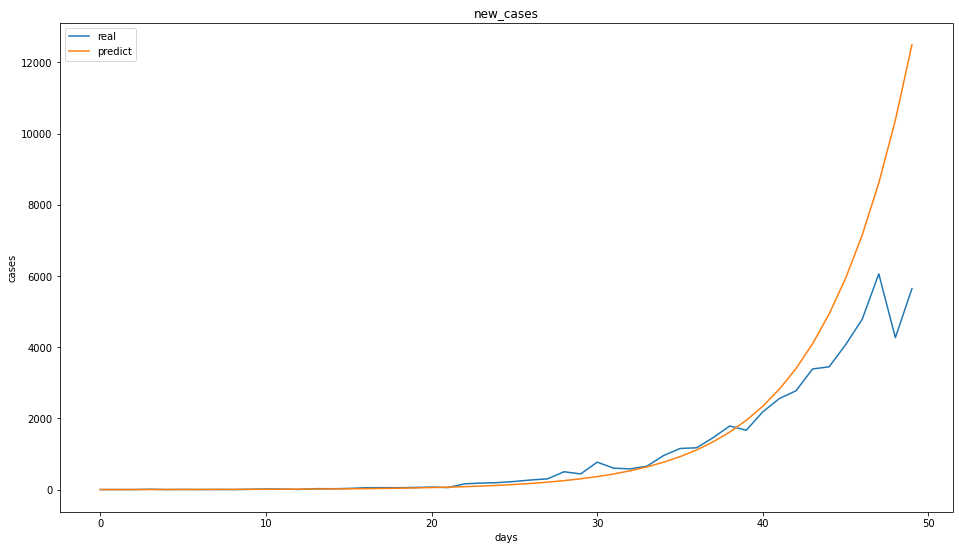

In [179]:
for i in range(len(targets)):
    plot_graphs(range(len(train_target.index)), [train_target[targets[i]], ys[i]],
                title=targets[i], labels=["real", "predict"],
                xlabel="days", ylabel="cases")

#### Подпункт B

Теперь посчитаем MAE для нашей модели (именно линейной, для $g = w * x + C2$). Эта ошибка по факту является значением дисперсии шума в данных  $\sigma^{2}$ (это фактически первый шаг эмпирического Байеса).

In [180]:
maes = []

for i in range(len(targets)):
    maes.append(mean_absolute_error(train_target_log[targets[i]], gs[i]))
    print("MAE for manual approach is {} for {} target".format(str(maes[i]), targets[i]))

MAE for manual approach is 0.2867742094023083 for total_cases target
MAE for manual approach is 0.4634998976530288 for new_cases target


Возьмем априорное распределение как $P(\overline{w}) = N(\overline{w} | 0, \alpha)$, где $\alpha$ - некий наперед заданный гиперпараметр (относящийся к параметру регуляризации), а $\overline{w} = [w, C2]^{T}$.  
Тогда по формуле для сопряженных априорных распределений к линейной регрессии, которую мы выводили на лекции, можно оценить апостериорное распределение $P(\overline{w} | D)$. Ведь все параметры для правдоподобия уже тоже посчитаны выше $P(D | \overline{w}) = \prod_{n = 1}^{50} p(y_{n} | \overline{w}, \overline{x}_{n}) = \prod_{n = 1}^{50} N(y_{n} | \overline{w} ^{T} \overline{x}_{n}, \sigma^{2})$

Непосредственно сама формула $P(\overline{w} | D) = N(\overline{w} | \mu_{N}, \Sigma_{N})$, где
$$
\frac{1}{\Sigma_{N}} = \frac{1}{\alpha} + \frac{1}{\sigma^{2}} X^{T} X,\\
\mu = \frac{1}{\sigma^{2}} \Sigma_{N} X^{T} \overline{y}.\\
$$

In [181]:
alphas = [value / 100. for value in range(1, 101, 10)]
mus = []

# for alpha in alphas:
# print((1 / alpha), maes[0] * sum([value ** 2 for value in range(51)]))
sigma_N_total = 1 / (1 / alphas[0] + maes[0] * sum([value ** 2 for value in range(51)]))
# print(sigma_N_total)
for i in range(len(train_target_log.index)):
    mus.append(sigma_N_total * maes[0] * i * train_target_log[targets[0]].iloc[i])

In [182]:
print(len(mus), len(train_target_log[targets[0]]))

mean_absolute_error(train_target_log[targets[0]], mus)

50 50


6.6741289172182645